In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim

from torchvision import datasets, transforms
import tqdm
from torchvision.utils import make_grid

import torch.distributions as tdist

import numpy as np
import tqdm

import matplotlib.pyplot as plt

In [ ]:
BATCH_SIZE = 100
EPOCHS = 100
VISIBLE_SIZE = 784
HIDDEN_SIZE = 100

In [ ]:
def visualize_RBM_weights(weights, grid_width, grid_height, slice_shape=(28, 28)):
    for idx in range(0, grid_width * grid_height):
        plt.subplot(grid_height, grid_width, idx+1)
        plt.imshow(weights[..., idx].reshape(slice_shape))
        plt.axis('off')

def sigmoid(x, gpu=True):
    if gpu:
      return 1 / (1 + torch.exp(-x))
    else:
      return 1 / (1 + np.exp(-x))
    

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases, h1_shape=(10, 10), v_shape=(28,28)):
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr, False), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(h1_shape[0] * h1_shape[1]):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr, False), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()

In [ ]:
train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=True, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./files', train=False, download=True,
                               transform=torchvision.transforms.Compose([
                                   torchvision.transforms.ToTensor()
                               ])), batch_size=BATCH_SIZE)

In [ ]:
class RBM():
    
    def __init__(self, visible_size, hidden_size, cd_k=1):
        self.v_size = visible_size
        self.h_size = hidden_size
        self.cd_k = cd_k
        
        normal_dist = tdist.Normal(0, 0.1)
        
        self.W = torch.Tensor(normal_dist.sample(sample_shape=(self.v_size, self.h_size))).cuda()
        self.v_bias = torch.Tensor(torch.zeros(self.v_size)).cuda()
        self.h_bias = torch.Tensor(torch.zeros(self.h_size)).cuda()


    def __call__(self, batch):
        return self.forward(batch)

    
    def forward(self, batch):
        return self._cd_pass(batch)
    
    
    def _cd_pass(self, batch):
        batch = batch.view(-1, 784)
        v0 = torch.bernoulli(batch)
        h0_prob = sigmoid(torch.matmul(v0, self.W) + self.h_bias)
        h0 = torch.bernoulli(h0_prob)

        h1 = h0

        for step in range(0, self.cd_k):
            v1_prob = sigmoid(torch.matmul(h1, self.W.T) + self.v_bias)
            v1 = torch.bernoulli(v1_prob)
            h1_prob = sigmoid(torch.matmul(v1, self.W) + self.h_bias)
            h1 = torch.bernoulli(h1_prob)
            
        return h0_prob, h0, h1_prob, h1, v1_prob, v1
    
    def reconstruct(self, h, gibbs_steps=None):
        h1 = h
        
        steps_to_do = self.cd_k
        if gibbs_steps is not None:
            steps_to_do = gibbs_steps

        for step in range(0, steps_to_do):
            v1_prob = sigmoid(torch.matmul(h1, self.W.T) + self.v_bias)
            v1 = torch.bernoulli(v1_prob)
            h1_prob = sigmoid(torch.matmul(v1, self.W) + self.h_bias)
            h1 = torch.bernoulli(h1_prob)

        return h1_prob, h1, v1_prob, v1

    
    def update_weights_for_batch(self, batch, learning_rate=0.01):
        h0_prob, h0, h1_prob, h1, v1_prob, v1 = self._cd_pass(batch)
        v0 = torch.bernoulli(batch)

        w_positive_grad = torch.matmul(v0.T, h0)
        w_negative_grad = torch.matmul(v1.T, h1)

        dw = (w_positive_grad - w_negative_grad) / batch.shape[0]

        self.W = self.W + learning_rate * dw
        self.v_bias = self.v_bias + learning_rate*torch.mean(v0-v1, dim=0)
        self.h_bias = self.h_bias + learning_rate*torch.mean(h0-h1, dim=0)

In [61]:
model = RBM(visible_size=VISIBLE_SIZE, hidden_size=HIDDEN_SIZE, cd_k=1)

for curr_epoch in tqdm.tqdm(range(0, EPOCHS)):
    for sample, label in train_loader:
        sample = sample.cuda()
        label = label.cuda()
        sample = sample.view(-1, 784)
        model.update_weights_for_batch(sample, 0.1)

100%|██████████| 100/100 [11:36<00:00,  6.96s/it]


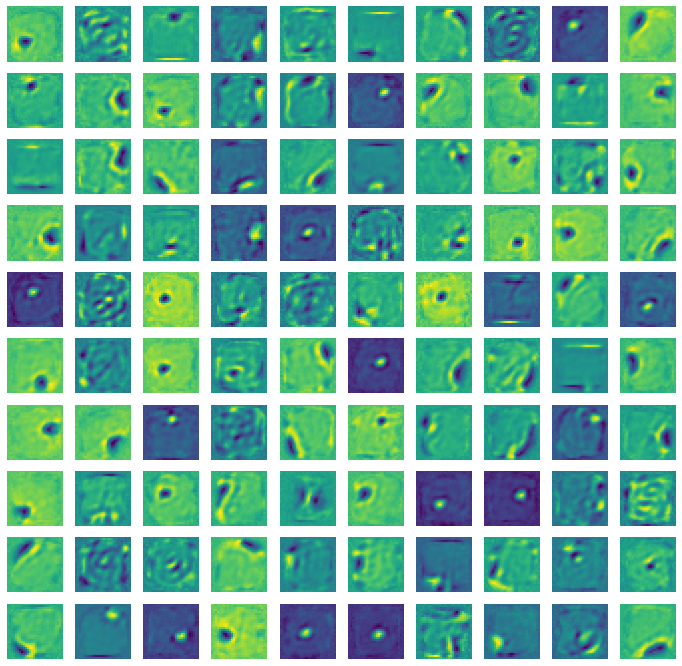

In [63]:
plt.figure(figsize=(12, 12), facecolor='w')
visualize_RBM_weights(model.W.data.cpu(), 10, 10)

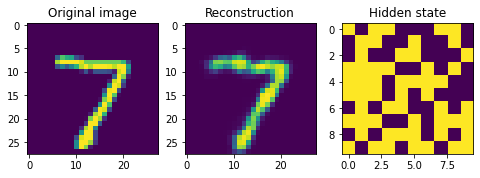

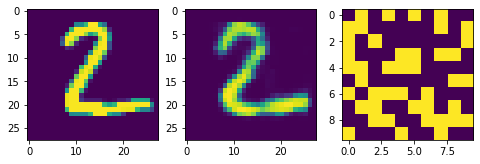

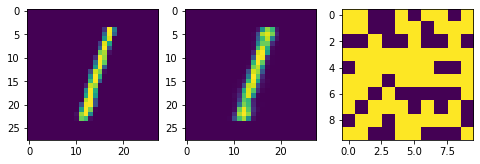

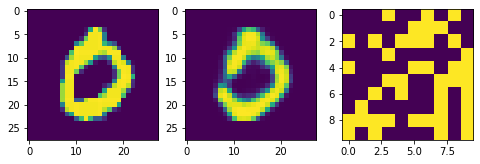

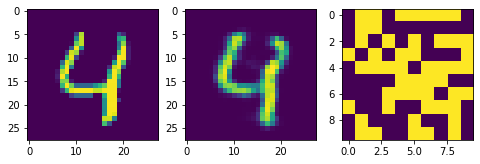

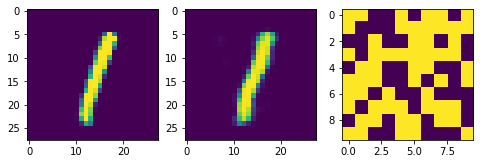

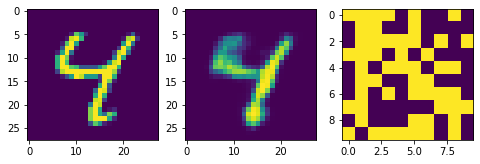

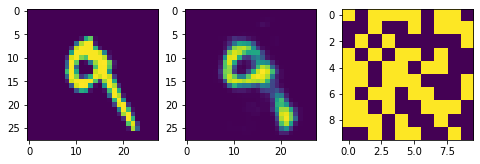

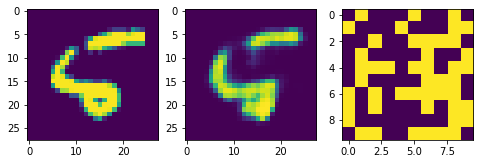

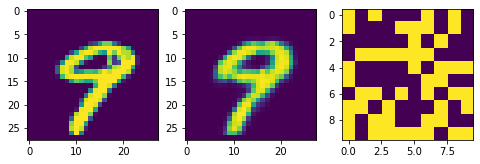

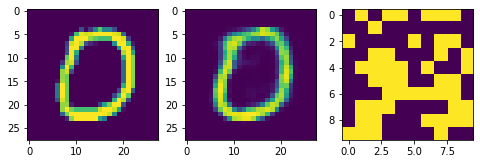

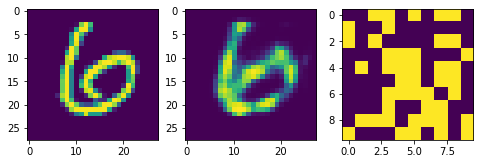

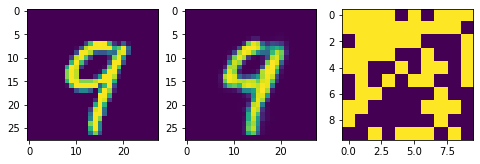

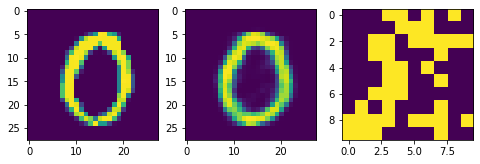

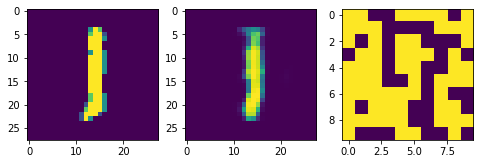

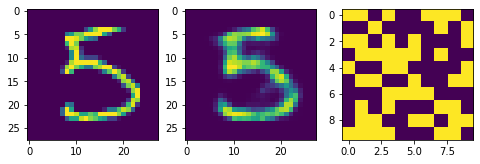

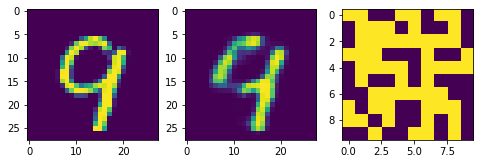

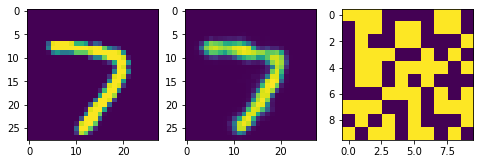

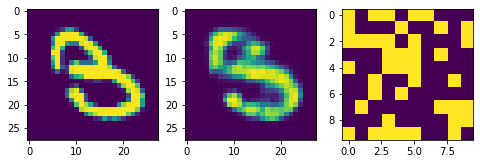

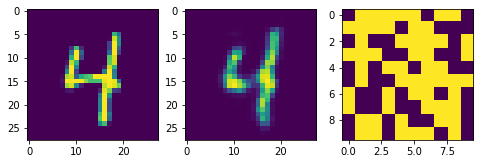

In [65]:
sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784).cuda()

for idx in range(0, 20): 
    h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)


    plt.figure(figsize=(8, 4), facecolor='w')
    plt.subplot(1, 3, 1)
    plt.imshow(sample[idx, ...].view(28, 28).cpu())
    if idx == 0:
        plt.title("Original image")

    plt.subplot(1, 3, 2)
    recon_image = v1_prob[idx, ...].view(28, 28)
    plt.imshow(recon_image.cpu().data)
    if idx == 0:
        plt.title("Reconstruction")
    
    plt.subplot(1, 3, 3)
    state_image = h1[idx, ...].view(10, 10)
    plt.imshow(state_image.cpu().data)
    if idx == 0:
        plt.title("Hidden state")

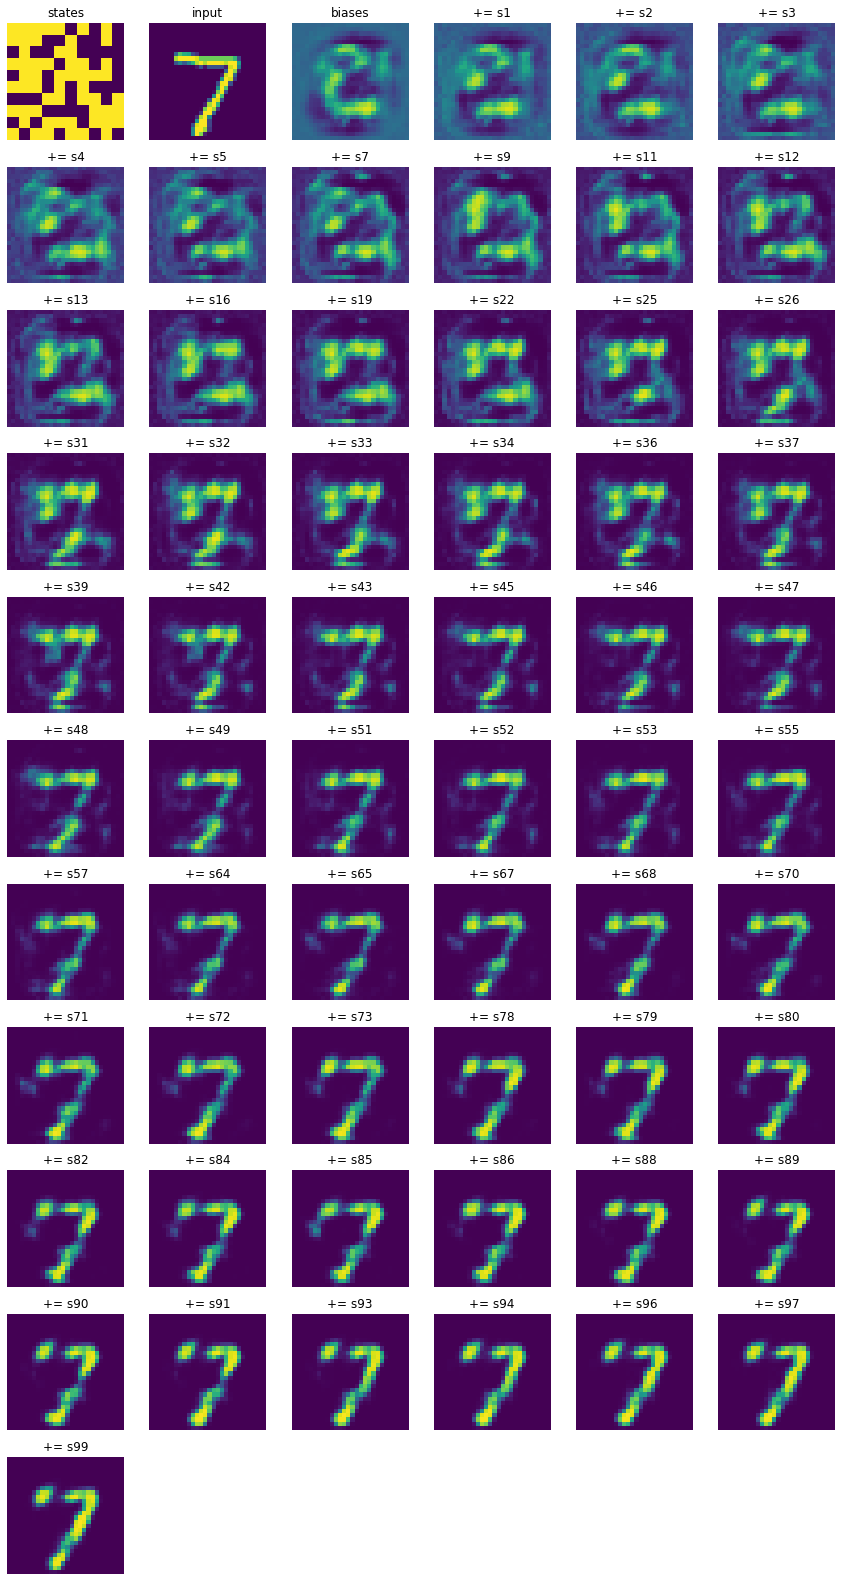

In [72]:
sample, _ = next(iter(test_loader))
sample = sample[0, ...].view(-1, 784).cuda()

h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)

reconstruct(0, h1.cpu().numpy(), sample.cpu().numpy(), model.W.cpu().numpy(), model.v_bias.cpu().numpy())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


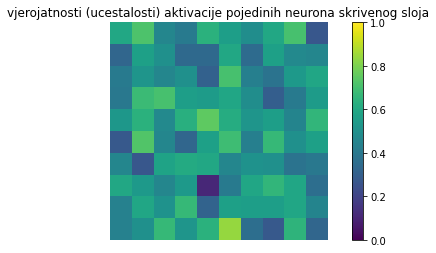

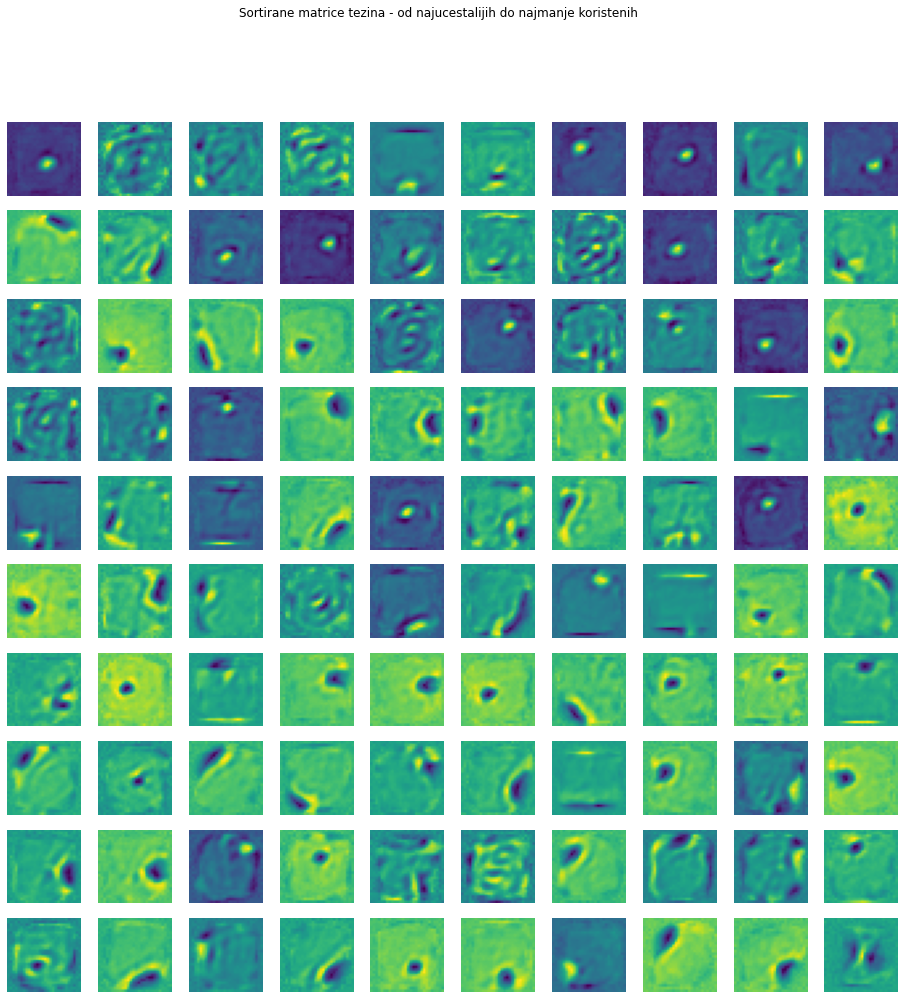

<Figure size 1152x1152 with 0 Axes>

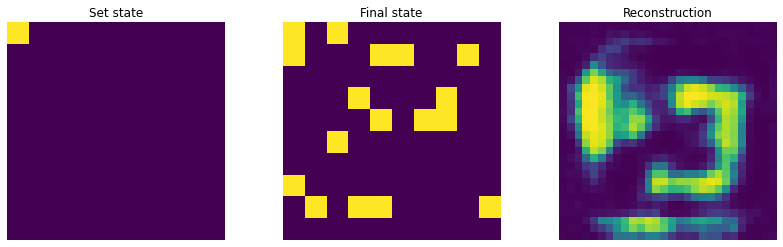

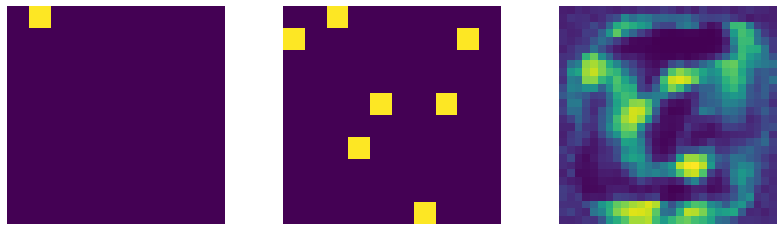

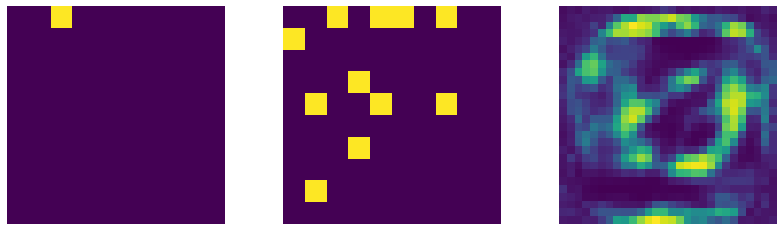

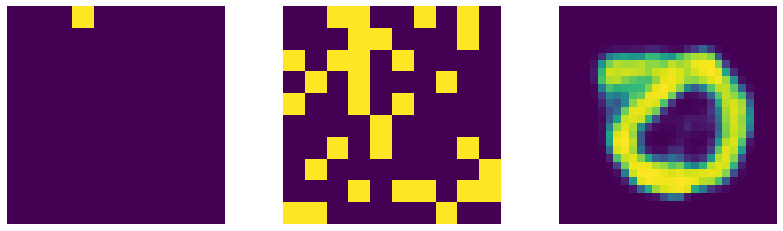

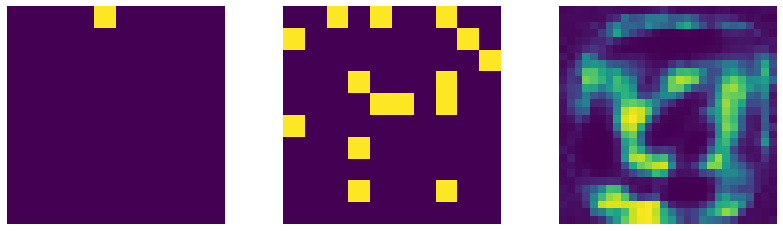

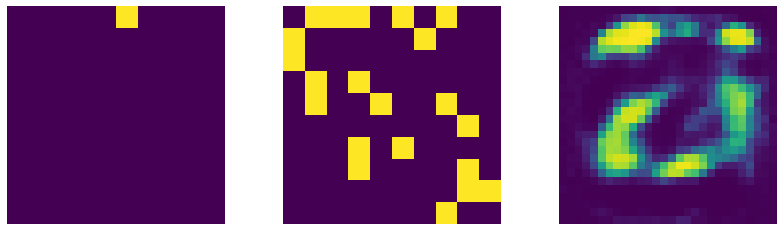

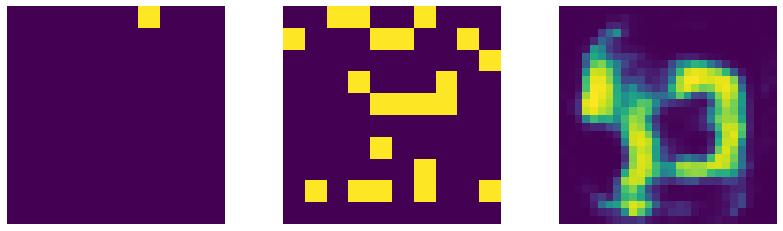

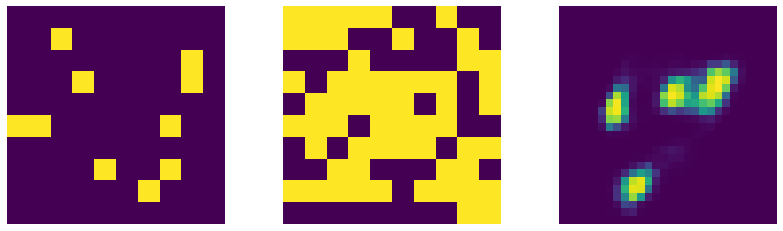

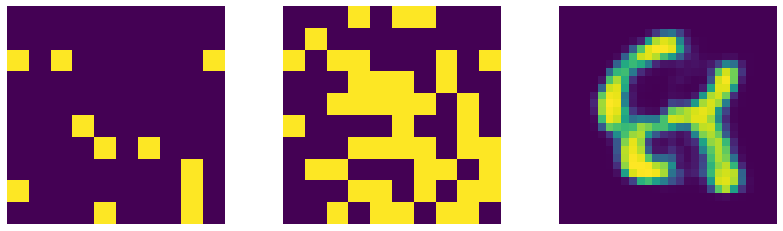

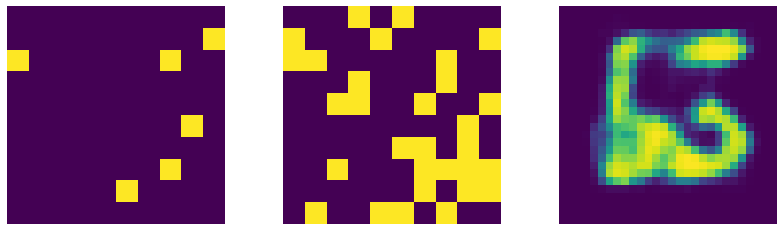

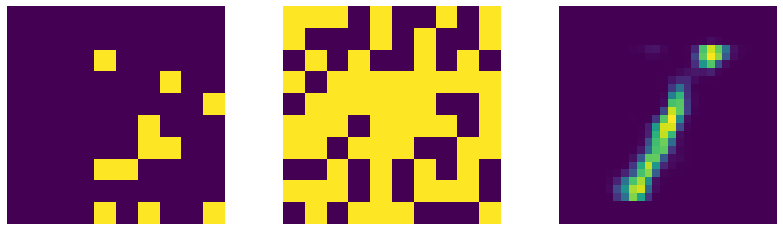

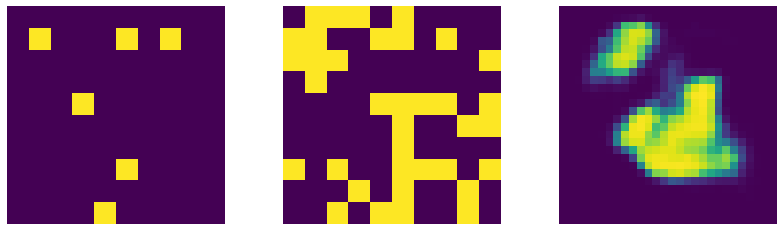

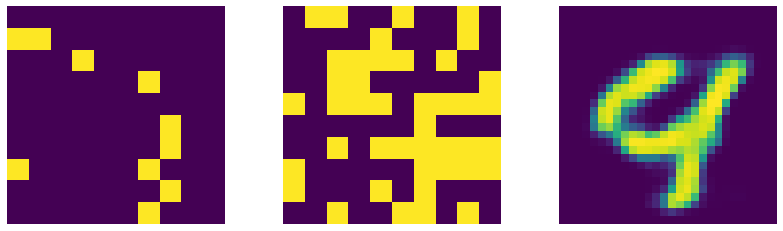

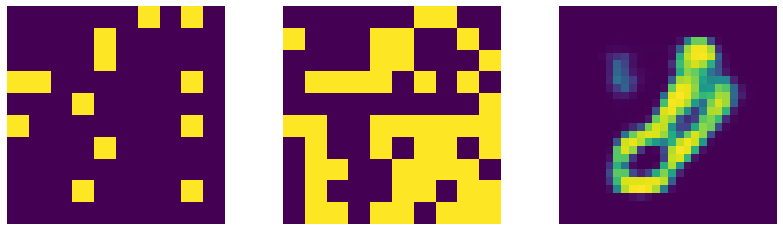

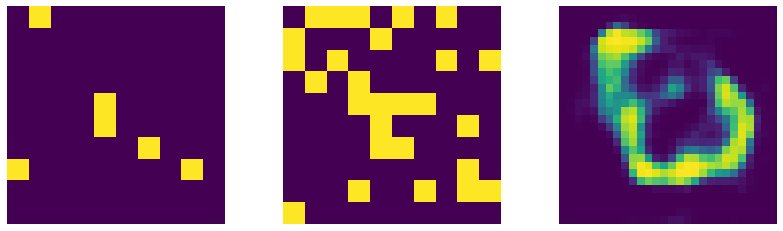

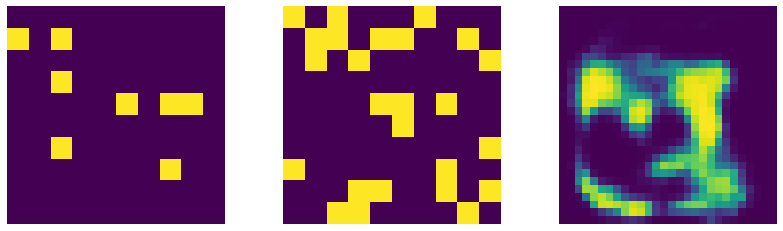

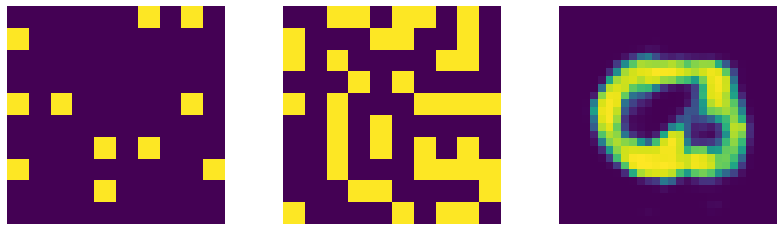

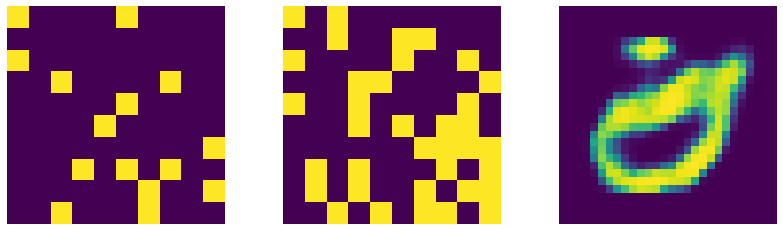

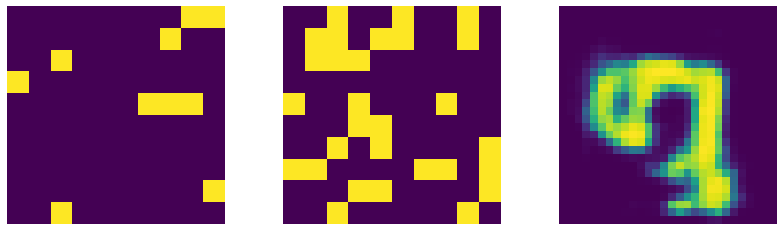

In [81]:
sample, _ = next(iter(test_loader))
sample = sample.view(-1, 784).cuda()

h0_prob, h0, h1_prob, h1, v1_prob, v1 = model(sample)

h0_prob, h0, h1_prob, h1, v1_prob, v1, model_weights, model_v_biases = list(map(lambda x: x.cpu().numpy(), [h0_prob, h0, h1_prob, h1, v1_prob, v1, model.W, model.v_bias]))


# Vjerojatnost da je skriveno stanje uključeno kroz Nu ulaznih uzoraka
plt.figure(figsize=(9, 4))
tmp = (h1.sum(0)/h1.shape[0]).reshape((10, 10))
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('vjerojatnosti (ucestalosti) aktivacije pojedinih neurona skrivenog sloja')

# Vizualizacija težina sortitranih prema učestalosti
plt.figure(figsize=(16, 16))
tmp_ind = (-tmp).argsort(None)
visualize_RBM_weights(model_weights[:, tmp_ind], 10, 10)
plt.suptitle('Sortirane matrice tezina - od najucestalijih do najmanje koristenih')


r_input = np.random.rand(100, HIDDEN_SIZE)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

h1_prob, h1, v1_prob, v1 = model.reconstruct(torch.from_numpy(r_input).cuda().float(), 19)

plt.figure(figsize=(16, 16))
for idx in range(0, 19):
    plt.figure(figsize=(14, 4))
    
    plt.subplot(1, 3, 1)
    plt.imshow(r_input[idx, ...].reshape(10, 10))
    if idx == 0:
        plt.title("Set state")
    plt.axis('off')
    
    plt.subplot(1, 3, 2)
    plt.imshow(h1[idx, ...].cpu().view(10, 10))
    if idx == 0:
        plt.title("Final state")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(v1_prob[idx, ...].cpu().view(28, 28))
    if idx == 0:
        plt.title("Reconstruction")
    plt.axis('off')